In [1]:
%matplotlib inline
import torchfilter as tfilter
import numpy as np
import pandas as pd
import pymap3d as pm
from matplotlib import pyplot as plt
import plotly.express as px
import torch
from tqdm.notebook import tqdm
from collections import namedtuple
import pytorch3d.transforms as tf
import xarray as xr

/home/groups/gracegao/conda_envs/deep_gnss/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import os, sys
sys.path.append('..')

from dynamics_models import *
from kf_measurement_models import *
from pf_measurement_models import *
from virtual_sensor_models import *
from utils import *
from filter_models import *

%load_ext autoreload
%autoreload 2

In [3]:
origin_lla, origin_ecef = get_reference_from_gt("22 18 04.31949  114 10 44.60559        3.472")   
origin_rpy = get_reference_rot("-1.7398149928   0.4409540487 -132.534729738")
origin_time = 1621218775.00

# origin_lla, origin_ecef = get_reference_from_gt("22 18 00.25350  114 10 47.25217        3.189") 
# origin_rpy = get_reference_rot("-0.6671978933   0.4780759843 137.9359508957")
# origin_time = 1621218838.00


# origin_lla, origin_ecef = get_reference_from_gt("22 17 51.54462  114 10 37.53472        2.433")  
# origin_rpy = get_reference_rot("-0.7491022101  -0.4393383077 -133.811686506")
# origin_time = 1621218900.00

# origin_lla, origin_ecef = get_reference_from_gt("22 17 49.70559  114 10 33.84846        3.084") 
# origin_rpy = get_reference_rot("1.5505269260   0.5986893297 -84.4024418600")
# origin_time = 1621218930.00

end_time = origin_time + 400 #+ 777.0

In [4]:
# Index/timestamp syncing management
utc_to_gt_idx = lambda x: int(x - 1621218775.00)
gt_idx_to_utc = lambda x: x + 1621218775.00

utc_to_gnss_idx = lambda x: int(x - 1621218785)
gnss_idx_to_utc = lambda x: x + 1621218785


In [5]:
gt_data = load_ground_truth("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/UrbanNav_TST_GT_raw.txt", origin_lla)
gt_pos = gt_data.sel(dim_1=["ENUX", "ENUY", "ENUZ"]).to_numpy()
gt_vel = gt_data.sel(dim_1=["VelBdyX", "VelBdyY", "VelBdyZ"]).to_numpy()
gt_acc = gt_data.sel(dim_1=["AccBdyX", "AccBdyY", "AccBdyZ"]).to_numpy()
gt_rot = gt_data.sel(dim_1=["Roll", "Pitch", "Heading"]).to_numpy()
gt_len = len(gt_pos)

In [6]:
gt_len

787

In [7]:
dd_data = load_dd_data(origin_lla, origin_ecef)

In [8]:
imu_data = xr.DataArray(pd.read_csv("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/xsense_imu_medium_urban1.csv"))

In [9]:
timestamp, or_quat, or_cov, ang_vel, ang_vel_cov, lin_acc, lin_acc_cov = parse_imu_data(imu_data)

In [10]:
imu_to_gt_idx = lambda i: utc_to_gt_idx(timestamp[i])
imu_to_gnss_idx = lambda i: utc_to_gnss_idx(timestamp[i])
utc_to_imu_idx = lambda x: np.argmin(np.abs(x - timestamp))

In [11]:
len(timestamp)

314194

In [12]:
def get_vo_data():
    vo_path = os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/')
    vo_vals = np.load(os.path.join(vo_path, "velocity_vo_15Hz.npy"))
    
    vo_times = np.load(os.path.join(vo_path, "velocity_vo_15Hz_timestamp.npy"))
    
    return {
        'vo': vo_vals.T,
        'timestamp': vo_times/1e9
    }
vo_data = get_vo_data()

In [13]:
imu_to_vo_idx_data = timestamp.copy()
vo_idx = 0
for i, t in tqdm(enumerate(timestamp)):
    while (t > vo_data["timestamp"][vo_idx]) and (vo_idx < len(vo_data["timestamp"])-1):
        vo_idx += 1
    imu_to_vo_idx_data[i] = vo_idx

imu_to_vo_idx = lambda i: imu_to_vo_idx_data[i]

0it [00:00, ?it/s]

In [14]:
def get_ints_data():
    int_hypo_path = os.path.abspath('/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/IntegerHypotheses')
    gps_ints = np.load(os.path.join(int_hypo_path, "true_gps_ints.npy"), allow_pickle=True).item()
    ref_gps = None # np.load("/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/IntegerHypotheses/ref_gps.npy", allow_pickle=True).item()

    mixed_ints = np.load("/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/IntegerHypotheses/true_mixed_ints.npy", allow_pickle=True).item()

    return {
        'mi': mixed_ints,
        'gi': gps_ints,
        'ref': ref_gps
    }
ints_data = get_ints_data()

In [15]:
def get_cycle_slip_data():
    cycle_slip_path = os.path.abspath('/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/cycle_slip_data/')
    _gps_cs = np.load(os.path.join(cycle_slip_path, 'gps mask_win5_thr3.npy'))
    _bei_cs = np.load(os.path.join(cycle_slip_path, 'bei mask_win5_thr3.npy'))

    mixed_cs = np.zeros((777, 31+32), dtype=np.bool)
    mixed_cs[5:, :31][_gps_cs==True] = True
    mixed_cs[5:, 31:][_bei_cs==True] = True
    return mixed_cs

mixed_data = get_cycle_slip_data()

<ipython-input-15-08f513d4ec1e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mixed_cs = np.zeros((777, 31+32), dtype=np.bool)


# Filter Code

In [213]:
N_dim = 31+32
# N_dim = 0
T_start = utc_to_imu_idx(origin_time)
T = utc_to_imu_idx(end_time)
state_dim = 10 + N_dim
IMU_rate_div = 10

dynamics_model = CarFullPoseDynamicsModel(N_dim=N_dim)
kf_measurement_model = IMU_VO_DD_MeasurementModel(dd_data['base_station_enu'].to_numpy(), N_dim=N_dim)
pf_measurement_model = GNSSPFMeasurementModel_IMU_DD_VO(dd_data['base_station_enu'].to_numpy(), N_dim=N_dim)

# test_filter = AsyncExtendedKalmanFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=kf_measurement_model,
#     )

# test_filter = AsyncParticleFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=pf_measurement_model,
#     resample=True,
#     estimation_method="weighted_average",
#     num_particles= 10000,
#     soft_resample_alpha=1.0,
# )

# test_filter = AsyncExtendedInformationFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=kf_measurement_model,    
# )

test_filter = AsyncRaoBlackwellizedParticleFilter(
    dynamics_model=dynamics_model,
    measurement_model=pf_measurement_model,
    resample=True,
    estimation_method="weighted_average",
    num_particles= 20,
    soft_resample_alpha=1.0,
)

# # Bank-of-EKF mode
# test_filter = AsyncRaoBlackwellizedParticleFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=pf_measurement_model,
#     estimation_method="weighted_average",
#     num_particles= 1,
#     soft_resample_alpha=1.0,
# )

pf_idx_mask = torch.zeros(state_dim, dtype=torch.bool)
pf_idx_mask[:3] = True

test_filter.attach_ekf(dynamics_model,kf_measurement_model, pf_idx_mask, bank_mode=False)

In [214]:
# m_model_params = list(pf_measurement_model.parameters())
# d_model_params = list(dynamics_model.parameters())
# m_model_params, d_model_params

In [215]:
# tmp_a = torch.ones(1, 10)

# for _ in range(10):
#     tmp_a, Q = dynamics_model(tmp_a, torch.ones(1, 6))
# tmp_obj = nll_objective(torch.tensor([1.0, 1.0, 1.0]).reshape(1, -1), tmp_a[:, :3], torch.diagonal(Q, dim1=-2, dim2=-1)[:, :3])
# print(tmp_obj)
# torch.autograd.grad(outputs=tmp_obj, inputs=d_model_params, allow_unused=True, retain_graph=True)

In [216]:
# optimizer = torch.optim.SGD(test_filter.parameters(), lr=0.01, momentum=0.9)
# optimizer.zero_grad()
# loss_fn = torch.nn.MSELoss()
# nll_objective = torch.nn.GaussianNLLLoss()

In [217]:
estimated_states = torch.zeros(T, state_dim)
estimated_states[T_start, 3] = 1 
prev_timestamp = timestamp[T_start] - 0.0025*IMU_rate_div

inter_const_bias = torch.tensor(dd_data['inter_const_bias'].to_numpy())

quat0 = eul2quat(origin_rpy)
quat0 = tf.quaternion_invert(quat0)

init_state = torch.zeros(state_dim)
init_state[3:7] = quat0

init_cov = 10*torch.eye(state_dim)
init_cov[:2, :2] *= 5.0    # x,y
init_cov[2, 2] *= 0.1    # z

init_cov[3:7, 3:7] *= 1e-2   # q_w
init_cov[3:7, 3:7] *= 1e-3   # q_x
init_cov[3:7, 3:7] *= 1e-3   # q_y
init_cov[3:7, 3:7] *= 1e-2   # q_z

init_cov[7:9, 7:9] *= 0.5   # v_x, v_y
init_cov[9, 9] *= 0.01   # v_z

test_filter.initialize_beliefs(
            mean=init_state[None, :].detach(),
            covariance=init_cov[None, :, :].detach(),
        )
    
recorded_data = {
    'controls': [],
    'imu_observation': [],
    'gnss_observation': [],
    'gnss_observation_context': [],
    'last_update': 0
}    
context = (prev_timestamp, 0, 0, recorded_data)
    
print("prev_timestamp: ", prev_timestamp)

prev_timestamp:  1621218775.5239782


In [218]:
def calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=None):
    # Check atleast 2 measurements in both code and carrier phase 
    if sum(idx_code_mask) < 2 or sum(idx_carr_mask) < 2:
        return (None, None, None, None)

    # First non-zero index is the reference
    if ref is None:
        ref = np.where(idx_code_mask & idx_carr_mask)[0][0]
#         ref = np.where(idx_code_mask[:31] & idx_carr_mask[:31])[0][-1]

    # Dont include reference in mask
    idx_code_mask[ref] = False
    idx_carr_mask[ref] = False

    # Compute double difference  
    dd_code, dd_carr = compute_d_diff(rover_code, base_code, rover_carr, base_carr, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask, ref_idx=ref)
    gnss_observation = data_tensor([dd_code, dd_carr])
    
    return gnss_observation, idx_code_mask, idx_carr_mask, ref

In [219]:
def calc_gnss_cov(cnos, satpos, pos, mode='simple'):
    if mode=='realni':
        los = satpos - pos[None, :]
        los = torch.div(los, torch.norm(los, dim=1)[:, None])
        el = torch.arccos(los[:, 2])

        s1 = 50
        A = 30
        s0 = 10 
        a = 50

        cno_term = cnos - s1
        cno_term_1 = torch.pow(10, -cno_term/a)
        cno_term_2 = cno_term/(s0-s1)
        s0_term = torch.pow(10, torch.tensor(-(s0-s1)/a))

        W = 1.0/torch.sin(el)**2*(cno_term_1*((A/s0_term - 1)*cno_term_2 + 1))
        
        sigma = 1./torch.sqrt(W)
    elif mode=='simple':
        ksnr = 100
        
        sigma = ksnr*torch.pow(10, -cnos/20)
    
    return sigma

def calc_ambiguity_cov(cs_data, idx_carr_mask):
    default_sigma = torch.ones(len(idx_carr_mask))
    default_sigma[cs_data==True] = 20.0
    return default_sigma

In [220]:
# # EKF Run code
# def run_timestep(t, context):
#     prev_timestamp, dd_idx, vo_idx, recorded_data = context
    
#     # Load IMU data
#     timestamp_t, or_quat_t, or_cov_t, ang_vel_t, ang_vel_cov_t, lin_acc_t, lin_acc_cov_t = timestamp[t], or_quat[t], or_cov[t], ang_vel[t], ang_vel_cov[t], lin_acc[t], lin_acc_cov[t]

#     # Compute time difference 
#     dt = (timestamp_t - prev_timestamp)
#     prev_timestamp = timestamp_t
#     test_filter.dynamics_model.update_dt_cov(dt, ang_vel_cov_t, lin_acc_cov_t)

#     # Predict step
#     controls = torch.cat((lin_acc_t, ang_vel_t)).float()
#     imu_observation = or_quat_t.float()
#     imu_observation[[1, 2]] = imu_observation[[2, 1]]
#     test_filter.measurement_model.update_imu_std(or_cov_t.float())
#     estimated_state = test_filter(controls=controls[None, :], observations=imu_observation[None, :])
# #     print("Heading: ", estimated_state[:, 3:7], tf.quaternion_invert(imu_observation))
    
#     tmp_outs_1 = {'predicted state': estimated_state.detach(), 'predicted cov': test_filter._belief_covariance.detach()}
# #     tmp_outs_1 = {'predicted state': test_filter.particle_states.detach(), 'predicted logwt': test_filter.particle_log_weights.detach()}
#     tmp_outs_2 = {'corrected state': estimated_state.detach(), 'corrected cov': test_filter._belief_covariance.detach()}
    
#     # Null corrected state and observation data
#     corrected_state = None
#     gnss_observation = None
#     gnss_observation_context = None
    
#     new_vo_idx = imu_to_vo_idx(t)
#     if new_vo_idx > vo_idx:
# #         print("VO update: ", t)
#         vo_idx = new_vo_idx
        
#         # VO does better at predicting low velocities
#         vo_val = np.linalg.norm(vo_data['vo'][vo_idx, :])/1.5              # VO velocity
# #         vo_val = gt_vel[imu_to_gt_idx(t), 1]           # Ground truth velocity
#         vo_observation = torch.zeros(1, 3)
#         vo_observation[0, 1] = vo_val
# #         if vo_val<3:
# #             test_filter.measurement_model.update_vo_std(1e-2)
# #         else:
# #             test_filter.measurement_model.update_vo_std(1e-4)
#         test_filter.measurement_model.update_vo_std(1e-3)
            
        
        
#         estimated_state = test_filter(controls=None, observations=vo_observation)
# #         expected_observation, R = test_filter.measurement_model.kalman_filter_measurement_model(estimated_state)
# #         print("Vel: ", estimated_state[0, 7:10], expected_observation, vo_observation)
        

#     new_dd_idx = imu_to_gnss_idx(t)
#     if new_dd_idx > dd_idx:
# #         print("GNSS update: ", t)
#         dd_idx = new_dd_idx

#         # Load GNSS observables
#         rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_idx, 'mixed'))

#         # Load Integer hypotheses
#         ref, N_hypo_dict = None, None
# #         ref, N_hypo_dict = get_N_hypotheses(timestamp_t, ints_data)

#         gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=ref)
        
#         if gnss_observation is not None:
            
#             # Cycle slip detection
#             cs_data = mixed_data[dd_idx, :]
        
#             # Dynamic covariances
#             cov_observation = calc_gnss_cov(rover_cnos, satpos, estimated_state[0, :3])
            
# #             cov_ambiguity = calc_ambiguity_cov(cs_data, idx_carr_mask)            
# #             test_filter.dynamics_model.update_ambiguity_cov(cov_ambiguity)

# #             visible_sats = sum(idx_code_mask)
# #             prange_std = 20.0/visible_sats
# #             carrier_std = 20.0/visible_sats if visible_sats<3 else 1.0/visible_sats
            
#             # Update satellite and other context data in the measurement model
#             test_filter.measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=N_hypo_dict, prange_std=cov_observation, carrier_noN_std=cov_observation, carrier_N_std=cov_observation*0.1)
#             gnss_observation_context = (satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias)

#             # Debug
#             tmp_state = torch.zeros(1, 10)
#             tmp_state[0, :3] = torch.tensor(gt_pos[imu_to_gt_idx(t), :])
#     #             expected_observation, R = test_filter.measurement_model.kalman_filter_measurement_model(tmp_state)

#     #             if N_hypo_dict is not None:
#     #                 print(expected_observation, gnss_observation)

#             # Update step
#             corrected_state = test_filter(observations=gnss_observation[None, :], controls=None)
            
#             print("Current err: ", torch.norm(corrected_state[0, :3] - tmp_state[0, :3]))

#             tmp_outs_2 = {'corrected state': corrected_state.detach(), 'corrected cov': test_filter._belief_covariance.detach()}
# #             tmp_outs_2 = {'corrected state': test_filter.particle_states.detach(), 'corrected logwt': test_filter.particle_log_weights.detach()}
            
#     # Ensure no NaN's so far
#     assert not (torch.any(torch.isnan(estimated_states[t-T_start, :])))
    
# #     recorded_data['controls'].append(controls)
# #     recorded_data['imu_observation'].append(imu_observation)
# #     recorded_data['gnss_observation'].append(gnss_observation)
# #     recorded_data['gnss_observation_context'].append(gnss_observation_context)
    
#     return estimated_state, corrected_state, (prev_timestamp, dd_idx, vo_idx, recorded_data), (tmp_outs_1, tmp_outs_2, prev_timestamp)

In [221]:
# For RBPF
jitter_measurement = 10

def run_timestep(t, context):
    prev_timestamp, dd_idx, vo_idx, recorded_data = context
    
    # Load IMU data
    timestamp_t, or_quat_t, or_cov_t, ang_vel_t, ang_vel_cov_t, lin_acc_t, lin_acc_cov_t = timestamp[t], or_quat[t], or_cov[t], ang_vel[t], ang_vel_cov[t], lin_acc[t], lin_acc_cov[t]

    # Compute time difference 
    dt = (timestamp_t - prev_timestamp)
    prev_timestamp = timestamp_t
    test_filter.update_dt_cov(dt, ang_vel_cov_t, lin_acc_cov_t)

    # Orientation (world -> body) to (body -> world)
#     or_quat_t[3] *= -1     # fix for ENU consistency

    # Predict step
    controls = torch.cat((lin_acc_t, ang_vel_t)).float()
    imu_observation = or_quat_t.float()
    imu_observation[[1, 2]] = imu_observation[[2, 1]]
    test_filter.update_imu_std(or_cov_t.float())
    estimated_state = test_filter(controls=controls[None, :], observations=imu_observation[None, :])
#     print("Heading: ", estimated_state[:, 3:7], tf.quaternion_invert(imu_observation))
    
    tmp_outs_1 = test_filter.tmp_outs
    tmp_outs_2 = test_filter.tmp_outs
    tmp_outs_2['corrected state'] = tmp_outs_2['predicted state']
    tmp_outs_2['corrected logwt'] = tmp_outs_2['predicted logwt']
    tmp_outs_2['corrected cov'] = tmp_outs_2['predicted cov']
    
    # Null corrected state and observation data
    corrected_state = None
    gnss_observation = None
    gnss_observation_context = None
    
    new_vo_idx = imu_to_vo_idx(t)
    if new_vo_idx > vo_idx:
#         print("VO update: ", t)
        vo_idx = new_vo_idx
        
        # VO does better at predicting low velocities
        vo_val = np.linalg.norm(vo_data['vo'][vo_idx, :])/1.5              # VO velocity
#         vo_val = gt_vel[imu_to_gt_idx(t), 1]           # Ground truth velocity
        vo_observation = torch.zeros(1, 3)
        vo_observation[0, 1] = vo_val
#         if vo_val<3:
#             test_filter.update_vo_std(1e-4)
#         else:
        test_filter.update_vo_std(1e-3)
            
        
        
        estimated_state = test_filter(controls=None, observations=vo_observation)
        expected_observation, R = test_filter.measurement_model.kalman_filter_measurement_model(estimated_state)
#         print("Vel: ", estimated_state[0, 7:10], expected_observation, vo_observation)
        

    new_dd_idx = imu_to_gnss_idx(t)
    if new_dd_idx > dd_idx:
#         print("GNSS update: ", t)
        dd_idx = new_dd_idx

        # Load GNSS observables
        rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_idx, 'mixed'))

        # Load Integer hypotheses
        ref, N_hypo_dict = None, None
#         ref, N_hypo_dict = get_N_hypotheses(timestamp_t, ints_data)

        gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=ref)
        
        if gnss_observation is not None:
            
            # Cycle slip detection
            cs_data = mixed_data[dd_idx, :]
        
            # Dynamic covariances
            cov_observation = calc_gnss_cov(rover_cnos, satpos, estimated_state[0, :3])
            
            cov_ambiguity = calc_ambiguity_cov(cs_data, idx_carr_mask)
            
            test_filter.update_ambiguity_cov(cov_ambiguity)
#             visible_sats = sum(idx_code_mask)
#             prange_std = 20.0/visible_sats
#             carrier_std = 20.0/visible_sats if visible_sats<3 else 1.0/visible_sats
            
            # Update satellite and other context data in the measurement model
            test_filter.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=N_hypo_dict, pf_std=(cov_observation*jitter_measurement, cov_observation*jitter_measurement, cov_observation*0.1*jitter_measurement), kf_std=(cov_observation, cov_observation, cov_observation*0.1))
            gnss_observation_context = (satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias)

            # Debug
            tmp_state = torch.zeros(1, 10)
            tmp_state[0, :3] = torch.tensor(gt_pos[imu_to_gt_idx(t), :])
    #             expected_observation, R = test_filter.measurement_model.kalman_filter_measurement_model(tmp_state)

    #             if N_hypo_dict is not None:
    #                 print(expected_observation, gnss_observation)

            # Update step
            corrected_state = test_filter(observations=gnss_observation[None, :], controls=None)
            
            print("Current err: ", torch.norm(corrected_state[0, :3] - tmp_state[0, :3]))

            tmp_outs_2 = test_filter.tmp_outs
            
    # Ensure no NaN's so far
    assert not (torch.any(torch.isnan(estimated_states[t-T_start, :])))
    
#     recorded_data['controls'].append(controls)
#     recorded_data['imu_observation'].append(imu_observation)
#     recorded_data['gnss_observation'].append(gnss_observation)
#     recorded_data['gnss_observation_context'].append(gnss_observation_context)
    
    return estimated_state, corrected_state, (prev_timestamp, dd_idx, vo_idx, recorded_data), (tmp_outs_1, tmp_outs_2, prev_timestamp)

In [222]:
tmp_outs = []
sync_gt = []

prev_gt_idx = -1

with torch.no_grad():
    for t in tqdm(range(T_start, T, IMU_rate_div)):
        estimated_state, corrected_state, context, _tmp_outs = run_timestep(t, context)
        if imu_to_gt_idx(t) != prev_gt_idx:
            prev_gt_idx = imu_to_gt_idx(t)
            tmp_outs.append(_tmp_outs)
            sync_gt.append(torch.tensor(gt_pos[prev_gt_idx, :]))
        
        if corrected_state is None:
            estimated_states[t, :] = estimated_state
        else:
            estimated_states[t, :] = corrected_state
            print("GT idx: ", prev_gt_idx)
#             # Update filter parameters
#             with torch.enable_grad():
                
#                 dynamics_objective = nll_objective(corrected_state.detach(), , torch.diagonal(Q, dim1=-2, dim2=-1)[:, :3])

  0%|          | 0/15979 [00:00<?, ?it/s]

Current err:  tensor(5.7373)
GT idx:  31
Current err:  tensor(6.1439)
GT idx:  32
Current err:  tensor(7.1730)
GT idx:  33
Current err:  tensor(9.9454)
GT idx:  34
Current err:  tensor(12.7340)
GT idx:  35
Current err:  tensor(13.3982)
GT idx:  36
Current err:  tensor(4.8514)
GT idx:  37
Current err:  tensor(3.4343)
GT idx:  38
Current err:  tensor(3.0352)
GT idx:  39
Current err:  tensor(2.9560)
GT idx:  40
Current err:  tensor(3.1309)
GT idx:  41
Current err:  tensor(3.4263)
GT idx:  42
Current err:  tensor(3.8171)
GT idx:  43
Current err:  tensor(4.2794)
GT idx:  44
Current err:  tensor(4.9980)
GT idx:  45
Current err:  tensor(5.5564)
GT idx:  46
Current err:  tensor(6.0479)
GT idx:  47
Current err:  tensor(6.7067)
GT idx:  48
Current err:  tensor(7.2599)
GT idx:  49
Current err:  tensor(7.7497)
GT idx:  50
Current err:  tensor(8.1785)
GT idx:  51
Current err:  tensor(8.4751)
GT idx:  52
Current err:  tensor(8.6934)
GT idx:  53
Current err:  tensor(8.8892)
GT idx:  54
Current err:  

Current err:  tensor(7.6917)
GT idx:  280
Current err:  tensor(8.4211)
GT idx:  281
Current err:  tensor(9.1298)
GT idx:  282
Current err:  tensor(8.4027)
GT idx:  283
Current err:  tensor(8.0547)
GT idx:  284
Current err:  tensor(8.4214)
GT idx:  285
Current err:  tensor(9.3970)
GT idx:  286
Current err:  tensor(15.7862)
GT idx:  290
Current err:  tensor(14.5004)
GT idx:  291
Current err:  tensor(17.6144)
GT idx:  292
Current err:  tensor(22.3848)
GT idx:  293
Current err:  tensor(14.7603)
GT idx:  294
Current err:  tensor(15.9651)
GT idx:  295
Current err:  tensor(8.9797)
GT idx:  296
Current err:  tensor(9.2017)
GT idx:  297
Current err:  tensor(10.8746)
GT idx:  298
Current err:  tensor(8.5948)
GT idx:  299
Current err:  tensor(8.5986)
GT idx:  300
Current err:  tensor(9.0329)
GT idx:  301
Current err:  tensor(9.0261)
GT idx:  302
Current err:  tensor(8.9541)
GT idx:  303
Current err:  tensor(8.9015)
GT idx:  304
Current err:  tensor(8.8612)
GT idx:  305
Current err:  tensor(8.7799

1621218806.0234077


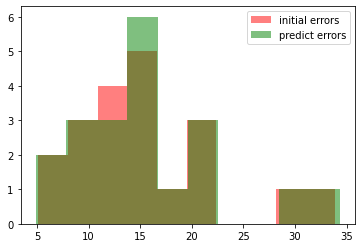

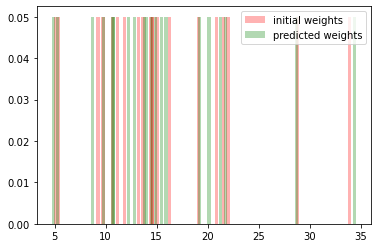

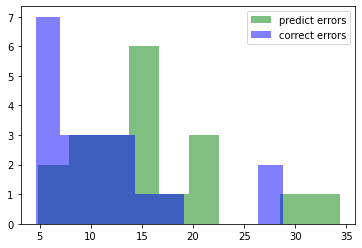

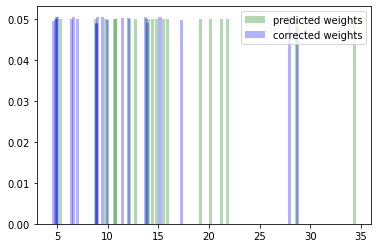

In [223]:
timestep = 31

print(tmp_outs[timestep][2])

get_error = lambda x, timestep: torch.norm(x[0, :, :3] - sync_gt[timestep], dim=-1) 

# Initial -> Predict
plt.hist(get_error(tmp_outs[timestep][0]['initial states'], timestep).numpy(), color='r', alpha=0.5, label='initial errors')
plt.hist(get_error(tmp_outs[timestep][0]['predicted state'], timestep).numpy(), color='g', alpha=0.5, label='predict errors')
plt.legend()
plt.show()

plt.bar(get_error(tmp_outs[timestep][0]['initial states'], timestep).numpy(), torch.exp(tmp_outs[timestep][0]['initial logwt'][0, :]).numpy(), width=0.3, color='r', alpha=0.3, label='initial weights')
plt.bar(get_error(tmp_outs[timestep][0]['predicted state'], timestep).numpy(), torch.exp(tmp_outs[timestep][0]['predicted logwt'][0, :]).numpy(), width=0.3, color='g', alpha=0.3, label='predicted weights')
plt.legend()
plt.show()

# Predict -> Update
if tmp_outs[timestep][1] is not None:
    plt.hist(get_error(tmp_outs[timestep][1]['initial states'], timestep).numpy(), color='g', alpha=0.5, label='predict errors')
    plt.hist(get_error(tmp_outs[timestep][1]['corrected state'], timestep).numpy(), color='b', alpha=0.5, label='correct errors')
    plt.legend()
    plt.show()
    
    plt.bar(get_error(tmp_outs[timestep][1]['initial states'], timestep).numpy(), torch.exp(tmp_outs[timestep][1]['initial logwt'][0, :]).numpy(), width=0.3, color='g', alpha=0.3, label='predicted weights')
    plt.bar(get_error(tmp_outs[timestep][1]['corrected state'], timestep).numpy(), torch.exp(tmp_outs[timestep][1]['corrected logwt'][0, :]).numpy(), width=0.3, color='b', alpha=0.3, label='corrected weights')
    plt.legend()
    plt.show()

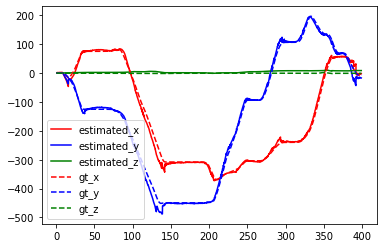

In [224]:
tmax = t-1

state_range = range(T_start, tmax, IMU_rate_div)
num_elem = len(state_range)

lower_gt = imu_to_gt_idx(T_start)
upper_gt = imu_to_gt_idx(tmax)

gt_len = upper_gt-lower_gt

states = estimated_states.detach()
plt.plot(np.linspace(1, gt_len, num=num_elem), states[state_range, 0], "r", label="estimated_x")
plt.plot(np.linspace(1, gt_len, num=num_elem), states[state_range, 1], "b", label="estimated_y")
plt.plot(np.linspace(1, gt_len, num=num_elem), states[state_range, 2], "g", label="estimated_z")

plt.plot(np.linspace(1, gt_len, num=gt_len), gt_pos[lower_gt:upper_gt, 0], "r--", label="gt_x")
plt.plot(np.linspace(1, gt_len, num=gt_len), gt_pos[lower_gt:upper_gt, 1], "b--", label="gt_y")
plt.plot(np.linspace(1, gt_len, num=gt_len), gt_pos[lower_gt:upper_gt, 2], "g--", label="gt_z")

# plt.plot(gt_pos[lower_t_s-root_t_s:, 0], "r--", label="gt_x")
# plt.plot(gt_pos[lower_t_s-root_t_s:, 1], "b--", label="gt_y")
# plt.plot(gt_pos[lower_t_s-root_t_s:, 2], "g--", label="gt_z")

plt.legend()

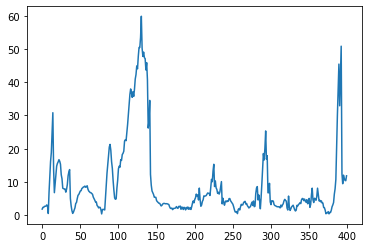

In [225]:
state_range = range(T_start, tmax, 400)
gt_range = [imu_to_gt_idx(t) for t in state_range]

tracking_error = torch.norm(states[state_range, :2] - gt_pos[gt_range, :2], dim=1)
plt.plot(tracking_error)
# plt.ylim((0, 2))

In [226]:
torch.mean(tracking_error)

tensor(9.2924, dtype=torch.float64)

In [529]:
test_filter.particle_log_weights

tensor([[-2.6204, -2.9803, -2.9535, -3.0314, -3.1245, -3.0062, -2.9315, -2.9579,
         -2.8580, -3.5544, -2.9630, -3.2153, -2.8419, -2.8718, -2.9522, -3.4906,
         -3.1208, -2.9055, -2.9558, -2.9746]])

In [532]:
test_filter.particle_states[0, :, :3], torch.sum(
                torch.exp(test_filter.particle_log_weights[:, :, np.newaxis])
                * test_filter.particle_states,
                dim=1,
            )[0, :3]

(tensor([[ -3.7602, -10.0149,   0.7574],
         [ -2.1490, -13.6567,   4.3466],
         [ -3.9965, -14.8795,   4.2408],
         [ -4.2462, -13.0363,   2.5249],
         [ -4.8837, -10.9676,   2.1322],
         [ -4.1375, -12.0028,   1.9055],
         [ -4.4640, -10.6087,   1.3913],
         [ -3.3351, -10.6943,   2.1355],
         [ -3.3593, -12.0124,   2.4433],
         [ -6.4332,  -9.8007,  -0.2426],
         [ -5.6419, -10.3134,   2.0603],
         [ -4.2642, -13.1017,   2.7025],
         [ -4.1685, -13.4230,   2.2401],
         [ -5.3640, -11.1050,   0.9993],
         [ -4.4026,  -9.6707,   0.6407],
         [ -2.9898,  -9.4507,   0.0561],
         [ -4.4787,  -9.3779,  -0.2631],
         [ -4.4537, -10.7572,   1.8295],
         [ -3.1819, -11.4238,   1.7459],
         [ -5.7400, -11.4670,   1.7845]]),
 tensor([ -4.2339, -11.4396,   1.8330]))

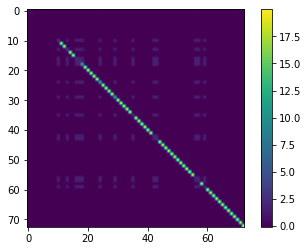

In [533]:
plt.imshow(test_filter.ekf._belief_covariance[0, :, :])
# plt.imshow(test_filter._belief_covariance[0, :, :])
plt.colorbar()
# torch.linalg.cond(test_filter.ekf._belief_covariance[0, :3, :3])


In [534]:
state_or_eul = np.stack(list(quaternion_to_euler_angle_vectorized(states[state_range, 3], -states[state_range, 4], -states[state_range, 5], -states[state_range, 6])), -1)

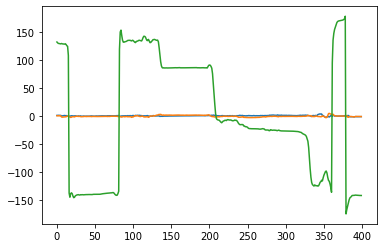

In [535]:
viz_block = range(0, len(state_or_eul))
plt.plot(state_or_eul[viz_block, 0])
plt.plot(state_or_eul[viz_block, 1])
plt.plot(state_or_eul[viz_block, 2])

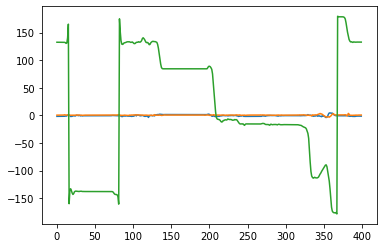

In [536]:
plt.plot(gt_rot[gt_range, 0])
plt.plot(gt_rot[gt_range, 1])
plt.plot(-gt_rot[gt_range, 2])

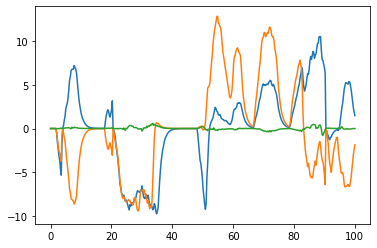

In [537]:
state_vel = states[state_range, 7:10].numpy()

viz_block_kHz = range(0, len(state_vel))
plt.plot(np.linspace(0, 100, num=len(viz_block_kHz)), state_vel[viz_block_kHz, 0])
plt.plot(np.linspace(0, 100, num=len(viz_block_kHz)), state_vel[viz_block_kHz, 1])
plt.plot(np.linspace(0, 100, num=len(viz_block_kHz)), state_vel[viz_block_kHz, 2])

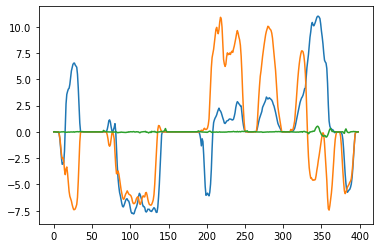

In [538]:
plt.plot(np.ediff1d(gt_pos[gt_range, 0]))
plt.plot(np.ediff1d(gt_pos[gt_range, 1]))
plt.plot(np.ediff1d(gt_pos[gt_range, 2]))

  0%|          | 0/63 [00:00<?, ?it/s]

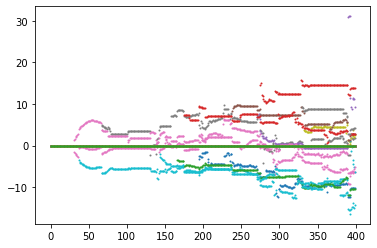

In [539]:
for i in tqdm(range(10, 10+31+32)):
    plt.scatter(range(len(state_range)), states[state_range, i].numpy(), s=1)

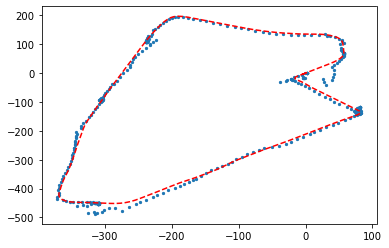

In [237]:
plt.scatter(states[state_range, 0], states[state_range, 1], s=5)
plt.plot(gt_pos[gt_range, 0], gt_pos[gt_range, 1], "r--")

In [118]:
save_data['weights'].shape

(400, 20)

In [236]:
save_data = {
    'states': np.array([tmp_outs[timestep][1]['corrected state'][0].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
    'weights': np.array([torch.exp(tmp_outs[timestep][1]['corrected logwt'][0]).numpy() for timestep in tqdm(range(len(tmp_outs)))]),
    'cov': np.array([tmp_outs[timestep][1]['corrected cov'].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
    'UTCtime': np.array([tmp_outs[timestep][2] for timestep in tqdm(range(len(tmp_outs)))]),
    'gt': np.array([sync_gt[timestep].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
}
np.save(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/rbpf_det_20p_9_4_1210_loop1.npy'), save_data)
# np.save(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/ekf_9_4_1130_loop1.npy'), save_data)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [396]:
# # with open(, 'wb') as f:
    
# save_data = {
#     'states': np.array([tmp_outs[timestep][0]['predicted state'][0].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
#     'weights': np.array([torch.exp(tmp_outs[timestep][0]['predicted logwt'][0]).numpy() for timestep in tqdm(range(len(tmp_outs)))]),
#     'cov': np.array([tmp_outs[timestep][0]['predicted cov'][0].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
#     'UTCtime': np.array([tmp_outs[timestep][2] for timestep in tqdm(range(len(tmp_outs)))]),
#     'gt': np.array([sync_gt[timestep].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
# }
# np.save(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/full_8_26_1830_1.npy'), save_data)

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

In [66]:
save_data = np.load(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/full_8_17_1515_1.npy'), allow_pickle=True).item()

In [263]:
def compute_tau_bisection(epsilon, diff_xh_xi, weights, init_tau=30.0):
    tau = init_tau
    
    for _ in range(20): 
        is_inside = diff_xh_xi < tau
        filter_integral = torch.sum(weights[is_inside])
        if filter_integral < 1 - epsilon:
            tau = 3/2 * tau
        else:
            tau = 1/2 * tau
            
    return tau

def compute_tau_empirical_sigma(epsilon, diff_xh_xi, weights):
    sigma = torch.sqrt(torch.sum(weights * torch.square(diff_xh_xi))) + 1e-6
    return torch.distributions.normal.Normal(loc=0.0, scale=sigma).icdf(torch.tensor(1-epsilon))

def compute_tau_sigma(epsilon, var, weights):
    sigma = torch.sqrt(torch.sum(weights * var)) + 1e-6
    return torch.distributions.normal.Normal(loc=0.0, scale=sigma).icdf(torch.tensor(1-epsilon))

def integrate_beliefs_1d(estimated_state, all_hypo_log_weights, all_hypo_states, all_hypo_cov, epsilon=0.01, dim=0):
    if len(all_hypo_states.shape)==2:
        all_hypo_states = all_hypo_states[None, :, :]
        all_hypo_log_weights = all_hypo_log_weights[None, :]
        all_hypo_cov = all_hypo_cov[None, :, :, :]
    
    num_hypo = all_hypo_log_weights.shape[0]
    
#     diff_xh_xi = torch.abs(estimated_state[dim] - all_hypo_states[:, :, dim])
    all_hypo_tau = torch.tensor([compute_tau_sigma(epsilon, all_hypo_cov[0, i, dim, dim], 1.0) for i in range(all_hypo_states.shape[1])])
    diff_xh_xi = torch.abs(estimated_state[dim] - all_hypo_states[:, :, dim]) + all_hypo_tau[None, :]
    print(all_hypo_tau, torch.sqrt(all_hypo_cov[:, :, dim, dim]))
#     diff_xh_xi = torch.abs(estimated_state[dim] - all_hypo_states[:, :, dim]) + torch.sqrt(all_hypo_cov[:, :, dim, dim])
    
    weights = torch.exp(all_hypo_log_weights)
    
#     diff_atau_xi = torch.abs(estimated_state[dim] + tau - all_hypo_states[:, :, dim])
#     diff_btau_xi = torch.abs(estimated_state[dim] - tau - all_hypo_states[:, :, dim])
    
#     diff_ptau_xi = torch.maximum(diff_atau_xi, diff_btau_xi)
#     diff_mtau_xi = torch.minimum(diff_atau_xi, diff_btau_xi)
    
    tau = compute_tau_empirical_sigma(epsilon, diff_xh_xi, weights)
#     tau = compute_tau_sigma(epsilon, all_hypo_cov[:, :, dim, dim], weights)

    #     sigma = 5.0 # all_hypo_cov[:, :, dim, dim]
    #     integral_xh_xi = torch.erf(diff_xh_xi/sigma)
    #     integral_ptau_xi = torch.erf(diff_ptau_xi/sigma)
    #     integral_mtau_xi = torch.erf(diff_mtau_xi/sigma)

    return tau
    

In [264]:
# plt.bar((torch.tensor(_init_particles[:, 0]) - estimated_state[0]).numpy(), _init_weights, alpha=0.3)

In [265]:
# for h in tqdm(range(all_hypo_states.shape[0])):
#     plt.bar((all_hypo_states[h, :, 0] - estimated_state[0]).numpy(), torch.exp(all_hypo_log_weights[h, :]).numpy(), width=0.8, alpha=0.2)

In [266]:
# metric_times = []

# T = len(save_data['UTCtime'])
# gnss_times = dd_data['time_gt'].to_numpy()

# i = 0
# i_N = 1

# for timestep in tqdm(range(i*int(T/i_N), (i+1)*int(T/i_N))):
#     _utctime = save_data['UTCtime'][timestep]
#     dd_tidx = np.argmin(np.abs(gnss_times - _utctime))
#     if np.abs(gnss_times[dd_tidx]-_utctime) > 1/40:
#         continue
    
#     # Load GNSS observables
#     rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))

#     gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=None)

#     if gnss_observation is None:
#         continue
    
#     metric_times.append(gnss_times[dd_tidx])
# # print(len(metric_times))
# np.save('/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/Filter_data/8_17_1000_times.npy', np.array(metric_times))

In [267]:
def single_hypo_update(_init_particles, _init_cov, _init_weights, gnss_observation, satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias, N_hypo_dict=None):
    M, state_dim = _init_particles.shape
    obs_dim = len(gnss_observation)
    
    test_filter.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=N_hypo_dict)

    # Run EKF correct
    test_filter.ekf._belief_mean = torch.tensor(_init_particles)
    test_filter.ekf._belief_covariance = torch.tensor(_init_cov)

    ekf_correct_particles = test_filter.ekf(controls=None, observations=gnss_observation.expand(M, obs_dim))

    _meas_log_weights = test_filter.measurement_model(
                    states=ekf_correct_particles[None, :, :],
                    observations=gnss_observation[None, :],
                )

    _update_log_weights = torch.log(torch.tensor(_init_weights[None, :])) + _meas_log_weights
    _update_log_weights -= torch.logsumexp(_update_log_weights, dim=1)
    
    return ekf_correct_particles.detach()[:, :3], test_filter.ekf._belief_covariance.detach()[:, :3, :3], _update_log_weights.detach()[0, :]

In [268]:
def get_uls():
#     gnss_times = dd_data['time_gt'].to_numpy()
#     test_filter.measurement_model.kalman_filter_measurement_model.gnss_model.carrier_N_std = 2.0
#     test_filter.ekf.measurement_model.gnss_model.carrier_N_std = 2.0

    ret_data = {
        'eul': [],
        'nul': [],
        'xh': [],
        'gt': []
    }

    T = len(save_data['UTCtime'])
    
    i = 0
    i_N = 1

    for timestep in tqdm(range(i*int(T/i_N), (i+1)*int(T/i_N))):
        _utctime = save_data['UTCtime'][timestep]
#         dd_tidx = np.argmin(np.abs(gnss_times - _utctime))
#         if np.abs(gnss_times[dd_tidx]-_utctime) > 1/40:
#             continue

#         # Load GNSS observables
#         rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))

        _init_particles = None
        _init_weights = None
#         all_hypo_states = torch.tensor(save_data['states'][timestep])[None, None, :]
        all_hypo_states = torch.tensor(save_data['states'][timestep])[None, :, :]
        
        state_dim = all_hypo_states.shape[-1]

#         all_hypo_log_weights = torch.zeros((1, 1, 1))
        all_hypo_log_weights = torch.log(torch.tensor(save_data['weights'][timestep]))[None, :]
        _gt = torch.tensor(save_data['gt'][timestep])

#         M, state_dim = _init_particles.shape

        _init_cov = None
#         all_hypo_cov = torch.tensor(save_data['cov'][timestep])[None, None, :, :] # 1.0*torch.eye(state_dim).expand(M, state_dim, state_dim)
        all_hypo_cov = torch.tensor(save_data['cov'][timestep])[None, :, :, :]
#         ref, N_hypo_dict_all = get_N_hypotheses(_utctime, ints_data)

#         gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=ref)

#         if gnss_observation is None:
#             continue
        
#         if N_hypo_dict_all is None:
#             _hypo_states, _hypo_cov, _hypo_log_weights = single_hypo_update(_init_particles, _init_cov, _init_weights, gnss_observation, satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias, N_hypo_dict=None)
            
#             all_hypo_states = _hypo_states.unsqueeze(0)
#             all_hypo_cov = _hypo_cov.unsqueeze(0)
#             all_hypo_log_weights = _hypo_log_weights.unsqueeze(0)
#         else:
#             avail_sat_idx = list(N_hypo_dict_all.keys())

#             num_hypo = len(N_hypo_dict_all[avail_sat_idx[0]])

#             all_hypo_states = []
#             all_hypo_cov = []
#             all_hypo_log_weights = []    
        

# #             tmp_state = torch.zeros(1, 10)
# #             tmp_state[0, :3] = torch.tensor(_gt)
# #             test_filter.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=None)
# #             expected_observation_gt, _ = test_filter.measurement_model.kalman_filter_measurement_model(tmp_state)

#             for hypo_idx in range(num_hypo):
#                 N_hypo_dict = {key: N_hypo_dict_all[key][hypo_idx] for key in avail_sat_idx}

#                 _hypo_states, _hypo_cov, _hypo_log_weights = single_hypo_update(_init_particles, _init_cov, _init_weights, gnss_observation, satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias, N_hypo_dict=N_hypo_dict)

#                 all_hypo_states.append(_hypo_states)
#                 all_hypo_cov.append(_hypo_cov)
#                 all_hypo_log_weights.append(_hypo_log_weights)

#             all_hypo_states = torch.stack(all_hypo_states)
#             all_hypo_cov = torch.stack(all_hypo_cov)
#             all_hypo_log_weights = torch.stack(all_hypo_log_weights) - np.log(num_hypo)

        estimated_state = torch.sum(
                    torch.exp(all_hypo_log_weights).reshape(-1)[:, None]
                    * all_hypo_states.reshape(-1, state_dim),
                    dim=0,
                )
    
        ret_data['eul'].append(integrate_beliefs_1d(estimated_state, all_hypo_log_weights, all_hypo_states, all_hypo_cov, dim=0))
        ret_data['nul'].append(integrate_beliefs_1d(estimated_state, all_hypo_log_weights, all_hypo_states, all_hypo_cov, dim=1))

        ret_data['xh'].append(estimated_state)
        ret_data['gt'].append(torch.tensor(_gt))

#         if timestep > i*int(T/10) + 0:
#             break
        
#         print(_utctime)
        
    return ret_data, (all_hypo_states, all_hypo_log_weights, estimated_state, torch.tensor(_gt), _init_particles, _init_weights)

ret_data, (all_hypo_states, all_hypo_log_weights, estimated_state, _gt, _init_particles, _init_weights) = get_uls()

  0%|          | 0/400 [00:00<?, ?it/s]

tensor([2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782,
        2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782,
        2.3782, 2.3782]) tensor([[1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223,
         1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223,
         1.0223, 1.0223]])
tensor([2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782,
        2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782, 2.3782,
        2.3782, 2.3782]) tensor([[1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223,
         1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223, 1.0223,
         1.0223, 1.0223]])
tensor([3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361,
        3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361, 3.2361,
        3.2361, 3.2361]) tensor([[1.3911, 1.3911, 1.3911, 1.3911, 1.3911, 1.3911, 1.3911, 1.

<ipython-input-268-fe8e9e0d03d2>:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ret_data['gt'].append(torch.tensor(_gt))


tensor([5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057,
        5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057, 5.6057,
        5.6057, 5.6057]) tensor([[2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097,
         2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097, 2.4097,
         2.4097, 2.4097]])
tensor([2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350,
        2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350, 2.2350,
        2.2350, 2.2350]) tensor([[0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607,
         0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607, 0.9607,
         0.9607, 0.9607]])
tensor([5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049,
        5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049, 5.6049,
        5.6049, 5.6049]) tensor([[2.4093, 2.4093, 2.4093, 2.4093, 2.4093, 2.4093, 2.4093, 2.

tensor([1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188,
        1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188, 1.8188,
        1.8188, 1.8188]) tensor([[0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818,
         0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818, 0.7818,
         0.7818, 0.7818]])
tensor([1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036,
        1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036, 1.5036,
        1.5036, 1.5036]) tensor([[0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463,
         0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463, 0.6463,
         0.6463, 0.6463]])
tensor([1.7164, 1.7164, 1.7164, 1.7164, 1.7164, 1.7164, 1.7164, 1.7164, 1.7164,
        1.7164, 1.7164, 1.7164, 1.7164, 1.7164, 1.7164, 1.7163, 1.7164, 1.7164,
        1.7164, 1.7164]) tensor([[0.7378, 0.7378, 0.7378, 0.7378, 0.7378, 0.7378, 0.7378, 0.

tensor([5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114,
        5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114, 5.5114,
        5.5114, 5.5114]) tensor([[2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691,
         2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691, 2.3691,
         2.3691, 2.3691]])
tensor([2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291,
        2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291, 2.4291,
        2.4291, 2.4291]) tensor([[1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442,
         1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442, 1.0442,
         1.0442, 1.0442]])
tensor([5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165,
        5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165, 5.5165,
        5.5165, 5.5165]) tensor([[2.3713, 2.3713, 2.3713, 2.3713, 2.3713, 2.3713, 2.3713, 2.

tensor([4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305,
        4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305, 4.0305,
        4.0305, 4.0305]) tensor([[1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325,
         1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325, 1.7325,
         1.7325, 1.7325]])
tensor([2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869,
        2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869, 2.3869,
        2.3869, 2.3869]) tensor([[1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260,
         1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260, 1.0260,
         1.0260, 1.0260]])
tensor([4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729,
        4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729, 4.4729,
        4.4729, 4.4729]) tensor([[1.9227, 1.9227, 1.9227, 1.9227, 1.9227, 1.9227, 1.9227, 1.

tensor([0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505,
        0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505, 0.8505,
        0.8505, 0.8505]) tensor([[0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656,
         0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656, 0.3656,
         0.3656, 0.3656]])
tensor([1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616,
        1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616, 1.0616,
        1.0616, 1.0616]) tensor([[0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563,
         0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563, 0.4563,
         0.4563, 0.4563]])
tensor([0.8355, 0.8355, 0.8355, 0.8354, 0.8354, 0.8355, 0.8355, 0.8355, 0.8355,
        0.8354, 0.8354, 0.8355, 0.8354, 0.8355, 0.8354, 0.8354, 0.8355, 0.8354,
        0.8355, 0.8354]) tensor([[0.3591, 0.3591, 0.3591, 0.3591, 0.3591, 0.3591, 0.3591, 0.

        0.6957, 0.6957]) tensor([[0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990,
         0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990, 0.2990,
         0.2990, 0.2990]])
tensor([3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139,
        3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139, 3.1139,
        3.1139, 3.1139]) tensor([[1.3385, 1.3385, 1.3385, 1.3385, 1.3386, 1.3385, 1.3385, 1.3385, 1.3385,
         1.3385, 1.3385, 1.3385, 1.3386, 1.3385, 1.3385, 1.3385, 1.3386, 1.3385,
         1.3385, 1.3385]])
tensor([0.8741, 0.8741, 0.8741, 0.8741, 0.8741, 0.8740, 0.8741, 0.8740, 0.8741,
        0.8740, 0.8741, 0.8740, 0.8741, 0.8741, 0.8741, 0.8741, 0.8741, 0.8741,
        0.8741, 0.8741]) tensor([[0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757,
         0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757, 0.3757,
         0.3757, 0.3757]])
tensor([3.3941, 3.3941, 3.3941, 3.3941

tensor([4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166,
        4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166, 4.0166,
        4.0166, 4.0166]) tensor([[1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266,
         1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266, 1.7266,
         1.7266, 1.7266]])
tensor([0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958,
        0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958, 0.8958,
        0.8958, 0.8958]) tensor([[0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851,
         0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851, 0.3851,
         0.3851, 0.3851]])
tensor([4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949,
        4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949, 4.2949,
        4.2949, 4.2949]) tensor([[1.8462, 1.8462, 1.8462, 1.8462, 1.8462, 1.8462, 1.8462, 1.

tensor([1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771,
        1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771, 1.0771,
        1.0771, 1.0771]) tensor([[0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630,
         0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630, 0.4630,
         0.4630, 0.4630]])
tensor([3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246,
        3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246, 3.2246,
        3.2246, 3.2246]) tensor([[1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861,
         1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861, 1.3861,
         1.3861, 1.3861]])
tensor([1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059,
        1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059, 1.5059,
        1.5059, 1.5059]) tensor([[0.6473, 0.6473, 0.6473, 0.6473, 0.6473, 0.6473, 0.6473, 0.

        0.6396, 0.6396]) tensor([[0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749,
         0.2750, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749, 0.2749,
         0.2749, 0.2749]])
tensor([2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293,
        2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293, 2.1293,
        2.1293, 2.1293]) tensor([[0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153,
         0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153, 0.9153,
         0.9153, 0.9153]])
tensor([0.6415, 0.6414, 0.6414, 0.6414, 0.6414, 0.6415, 0.6414, 0.6414, 0.6415,
        0.6415, 0.6414, 0.6415, 0.6414, 0.6415, 0.6414, 0.6414, 0.6414, 0.6414,
        0.6414, 0.6415]) tensor([[0.2758, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757,
         0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757, 0.2757,
         0.2757, 0.2758]])
tensor([2.0856, 2.0856, 2.0856, 2.0856

tensor([0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612,
        0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612, 0.6612,
        0.6612, 0.6612]) tensor([[0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842,
         0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842, 0.2842,
         0.2842, 0.2842]])
tensor([0.9544, 0.9545, 0.9544, 0.9544, 0.9544, 0.9544, 0.9544, 0.9545, 0.9544,
        0.9544, 0.9544, 0.9544, 0.9544, 0.9544, 0.9544, 0.9544, 0.9544, 0.9544,
        0.9544, 0.9544]) tensor([[0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103,
         0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103, 0.4103,
         0.4103, 0.4103]])
tensor([0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952,
        0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952, 0.6952,
        0.6952, 0.6952]) tensor([[0.2988, 0.2988, 0.2988, 0.2988, 0.2988, 0.2988, 0.2988, 0.

tensor([0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216,
        0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216, 0.9216,
        0.9216, 0.9216]) tensor([[0.3961, 0.3961, 0.3962, 0.3962, 0.3962, 0.3962, 0.3962, 0.3961, 0.3961,
         0.3962, 0.3962, 0.3962, 0.3962, 0.3962, 0.3961, 0.3961, 0.3962, 0.3962,
         0.3961, 0.3962]])
tensor([0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329,
        0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329, 0.9329,
        0.9329, 0.9329]) tensor([[0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010,
         0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010, 0.4010,
         0.4010, 0.4010]])
tensor([0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008,
        0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008, 0.9008,
        0.9008, 0.9008]) tensor([[0.3872, 0.3872, 0.3872, 0.3872, 0.3872, 0.3872, 0.3872, 0.

<ipython-input-268-fe8e9e0d03d2>:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return ret_data, (all_hypo_states, all_hypo_log_weights, estimated_state, torch.tensor(_gt), _init_particles, _init_weights)


(0.0, 50.0)

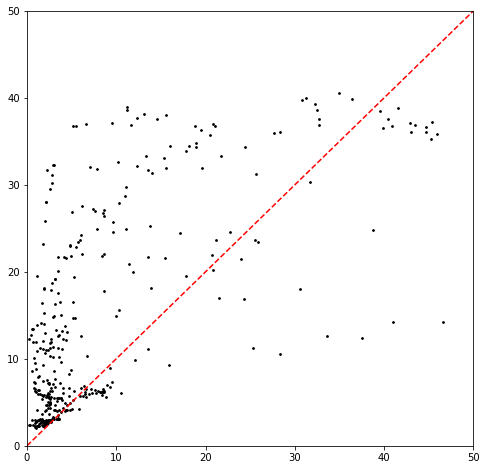

In [269]:
run_x_hat = torch.stack(ret_data['xh'])
run_gt = torch.stack(ret_data['gt'])

overall_pe = torch.norm((run_x_hat[:, :2]-run_gt[:, :2]), dim=1)
overall_ul = torch.maximum(torch.stack(ret_data['nul']), torch.stack(ret_data['eul']))

# mask = overall_ul>50.0

# run_x_hat[mask] = np.nan
# run_gt[mask] = np.nan
# overall_pe[mask] = np.nan
# overall_ul[mask] = 50.0

# print(torch.sum((overall_ul<overall_pe)&(overall_pe>15.0))/len(overall_pe))

plt.figure(figsize=(8, 8))
plt.scatter(overall_pe, overall_ul, color='k', s=3)
plt.plot([0, 50], [0, 50], 'r--')
plt.xlim([0, 50])
plt.ylim([0, 50])

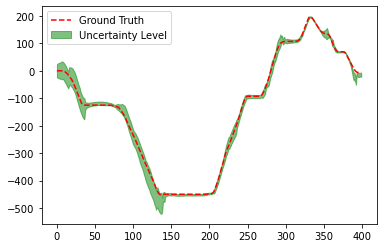

In [270]:
dim = 1

plt.fill_between(range(len(run_gt)), run_x_hat[:, dim] - overall_ul, run_x_hat[:, dim] + overall_ul, color='g', alpha=0.5, label='Uncertainty Level')
# plt.plot(run_x_hat[:, dim], 'r', label='State Estimate')
plt.plot(run_gt[:, dim], 'r--', label='Ground Truth')
plt.legend()

In [96]:
metric_data = pd.DataFrame({'x_hat_e': run_x_hat.numpy()[:, 0], 'x_hat_n': run_x_hat.numpy()[:, 1], 'gt_e': run_gt.numpy()[:, 0], 'gt_n': run_gt.numpy()[:, 1], 'pe': overall_pe, 'ul': overall_ul})
metric_data.to_csv('/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/Filter_data/8_17_1430_half2_ekf.csv')

In [ ]:
# observation_dim = test_filter.measurement_model.observation_dim

# def temp_f(states, satXYZb, base_pos, ref_idx, idx_code_mask, idx_carr_mask):
#     N, state_dim = states.shape
#     pos = states[:, :3]
# #         bias = states[:, self.idx_b_mask]

#     # ROVER
#     expected_observation_code = torch.linalg.norm(satXYZb[None, idx_code_mask, :3] - pos[:, None, :], dim=-1)
#     expected_observation_carr = torch.linalg.norm(satXYZb[None, idx_carr_mask, :3] - pos[:, None, :], dim=-1)


#     # ROVER - BASE
#     expected_observation_code -= torch.linalg.norm(satXYZb[None, idx_code_mask, :3] - base_pos[None, None, :], dim=-1)
#     expected_observation_carr -= torch.linalg.norm(satXYZb[None, idx_carr_mask, :3] - base_pos[None, None, :], dim=-1)

    
#     ## REFERENCE
    
#     # ROVER
#     expected_observation_code_ref = torch.linalg.norm(satXYZb[None, ref_idx, :3] - pos[:, :], dim=-1)
#     expected_observation_carr_ref = torch.linalg.norm(satXYZb[None, ref_idx, :3] - pos[:, :], dim=-1)


#     # ROVER - BASE
#     expected_observation_code_ref -= torch.linalg.norm(satXYZb[None, ref_idx, :3] - base_pos[None, :], dim=-1)
#     expected_observation_carr_ref -= torch.linalg.norm(satXYZb[None, ref_idx, :3] - base_pos[None, :], dim=-1)
    
    
#     # DOUBLE DIFFERENCE
#     expected_observation_code = expected_observation_code - expected_observation_code_ref[:, None]
#     expected_observation_carr = expected_observation_carr - expected_observation_carr_ref[:, None]

#     expected_observation = torch.cat((expected_observation_code, expected_observation_carr), -1)

#     return expected_observation.float()

# with torch.enable_grad():
#     x = pred_mean.detach().clone()

#     N, ndim = x.shape
    
#     x = x[:, None, :].expand((N, observation_dim, ndim))
#     x.requires_grad_(True)
#     y = test_filter.measurement_model(x.reshape((-1, ndim)))[0].reshape((N, -1, observation_dim))
#     mask = torch.eye(observation_dim, device=x.device).repeat(N, 1, 1)
#     jac = torch.autograd.grad(y, x, mask, create_graph=True)
# jac[0]

In [ ]:
# ## Fiter

# t = 1
# timestamp, or_quat, or_cov, ang_vel, ang_vel_cov, lin_acc, lin_acc_cov = parse_imu_data(imu_data[t-1])
# dt = (timestamp - prev_timestamp)
# prev_timestamp = timestamp
# or_quat = tf.quaternion_invert(or_quat)
# controls = torch.cat((lin_acc, ang_vel, or_quat)).float()

# prev_mean = test_filter._belief_mean
# prev_covariance = test_filter._belief_covariance
# N, state_dim = prev_mean.shape

# # Compute mu_{t+1|t}, covariance, and Jacobian
# pred_mean, dynamics_tril = test_filter.dynamics_model(
#     initial_states=prev_mean, controls=controls[None, :]
# )

# dynamics_covariance = dynamics_tril @ dynamics_tril.transpose(-1, -2)
# dynamics_A_matrix = test_filter.dynamics_model.jacobian(
#     initial_states=prev_mean, controls=controls[None, :]
# )

# # Calculate Sigma_{t+1|t}
# pred_covariance = (
#     dynamics_A_matrix @ prev_covariance @ dynamics_A_matrix.transpose(-1, -2)
#     + dynamics_covariance
# )

# test_filter.measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref)

# observations = observation[None, :]
# # Measurement model forward pass, Jacobian
# observations_mean = observations
# pred_observations, observations_tril = test_filter.measurement_model(states=pred_mean)
# observations_covariance = observations_tril @ observations_tril.transpose(
#     -1, -2
# )

# print(pred_mean)

# C_matrix = test_filter.measurement_model.jacobian(states=pred_mean)
# # Compute Kalman Gain, innovation
# innovation = observations_mean - pred_observations
# innovation_covariance = (
#     C_matrix @ pred_covariance @ C_matrix.transpose(-1, -2)
#     + observations_covariance
# )
# kalman_gain = (
#     pred_covariance
#     @ C_matrix.transpose(-1, -2)
#     @ torch.inverse(innovation_covariance)
# )

# # Get mu_{t+1|t+1}, Sigma_{t+1|t+1}
# corrected_mean = pred_mean + (kalman_gain @ innovation[:, :, None]).squeeze(-1)

# identity = torch.eye(test_filter.state_dim, device=kalman_gain.device)
# corrected_covariance = (identity - kalman_gain @ C_matrix) @ pred_covariance

In [ ]:
# ## DEBUG

# rover_code = dd_data[constellation+'_rover_measurements_code'][dd_tidx].to_numpy()
# base_code = dd_data[constellation+'_base_measurements_code'][dd_tidx].to_numpy()

# rover_carr = dd_data[constellation+'_rover_measurements_carr'][dd_tidx].to_numpy()
# base_carr = dd_data[constellation+'_base_measurements_carr'][dd_tidx].to_numpy()

# idx_code_mask = np.logical_not(np.isnan(rover_code))
# idx_carr_mask = np.logical_not(np.isnan(rover_carr))

# satpos = torch.tensor(dd_data[constellation+'_ecef_svs'][dd_tidx].to_numpy())
# ref = np.where(idx_code_mask & idx_carr_mask)[0][0]

# sd_code = rover_code - base_code
# dd_code = sd_code - sd_code[ref]

# sd_carr = rover_carr - base_carr
# dd_carr = sd_carr - sd_carr[ref]

# # Dont include reference
# idx_code_mask[ref] = False
# idx_carr_mask[ref] = False

# observation = torch.tensor(np.concatenate((dd_code[idx_code_mask], dd_carr[idx_carr_mask]), -1), dtype=torch.float32)

# kf_measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref)

# print("expected: ", kf_measurement_model(estimated_states[0, :][None, :])[0])
# print("measured: ", observation)

# Residual Computation

In [153]:
# # Print number of measurements at each time
# sum(~np.isnan(dd_data.beidou_base_measurements_carr).T)

In [154]:
inter_const_bias = torch.tensor(dd_data['inter_const_bias'].to_numpy()).float()

In [155]:
lda_scale = torch.ones(31+32)
lda_scale[:31] = 0.1902
lda_scale[31:] = 0.1920

In [156]:
utc2gps(dd_data['time_gt'][0].to_numpy())

95603.0

In [186]:
# Residual computation
T = len(dd_data['time_gt'])
code_sd_residuals = torch.zeros(T, 32+31).float()
code_sd_residuals[...] = float('nan') 
carr_sd_residuals = torch.zeros(T, 32+31).float()
carr_sd_residuals[...] = float('nan')
base_pose = torch.tensor(dd_data['base_station_enu'].to_numpy())[None, :]


for dd_tidx in tqdm(range(T)):
    rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))
    if sum(idx_code_mask) > 1 and sum(idx_carr_mask) > 1:
        dd_code, dd_carr = compute_s_diff(rover_code, base_code, rover_carr, base_carr, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask)
#         print("time: ", utc2gps(dd_data['time_gt'].to_numpy()[dd_tidx]))
#         print("rover_carr: ", rover_carr)
#         print("base_carr: ", base_carr)
#         print("sv idx: ", torch.where(idx_carr_mask))
#         print("SD carr: ", dd_carr)
        dd_code_expec, dd_carr_expec = expected_s_diff(satpos, torch.tensor(gt_pos[None, dd_tidx+10, :3]), base_pose, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask)
#         code_sd_residuals[dd_tidx, idx_code_mask] = torch.round(torch.divide(dd_code.float() - dd_code_expec[0, :].float() - inter_const_bias[idx_code_mask], lda_scale[idx_code_mask]))
#         carr_sd_residuals[dd_tidx, idx_carr_mask] = torch.round(torch.divide(dd_carr.float() - dd_carr_expec[0, :].float() - inter_const_bias[idx_carr_mask], lda_scale[idx_carr_mask]))
        code_sd_residuals[dd_tidx, idx_code_mask] = torch.round(torch.divide(dd_code.float() - inter_const_bias[idx_code_mask], lda_scale[idx_code_mask]))
        carr_sd_residuals[dd_tidx, idx_carr_mask] = torch.round(torch.divide(dd_carr.float() - inter_const_bias[idx_carr_mask], lda_scale[idx_carr_mask]))



  0%|          | 0/777 [00:00<?, ?it/s]

(0.0, 777.0)

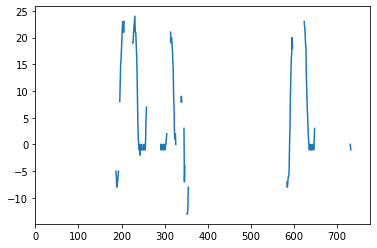

In [187]:
# plt.plot(np.diff(carr_sd_residuals[:, :] - carr_sd_residuals[:, 19:20], axis=0))
plt.plot(np.diff(carr_sd_residuals[:, 0] - carr_sd_residuals[:, 19], axis=0))
plt.xlim((0, 777))

In [ ]:
true_gps_ints = {key: dict() for key in ref_gps.keys()}
true_mixed_ints = {key: dict() for key in ref_gps.keys()}
for key in N_hypo_data.keys():
    ref_idx = int(ref_gps[key])
    t = int(float(key)) - 95603
    DD_N_vec = carr_sd_residuals[t, :] - carr_sd_residuals[t, ref_idx:ref_idx+1]
    for i, N_val in enumerate(DD_N_vec):
        if ~(np.isnan(N_val.item()) or torch.abs(N_val)<1e-5):
            if i<31:
                true_gps_ints[key]['['+str(i)+']'] = N_val.item()
            else:
                true_mixed_ints[key]['['+str(i-31)+']'] = N_val.item()

In [ ]:
true_gps_ints

In [ ]:
np.save(os.path.join(int_hypo_path, 'true_mixed_ints.npy'), true_mixed_ints)
np.save(os.path.join(int_hypo_path, 'true_gps_ints.npy'), true_gps_ints)

In [ ]:
plt.plot(carr_sd_residuals - carr_sd_residuals[:, 19:20])

In [ ]:
# Possible references
torch.where(torch.sum(~torch.isnan(code_sd_residuals), dim=0)>0)

In [ ]:
def calc_icb(residuals, ref=-1, const1_max_idx=31, plot=True):
    max_idx = residuals.shape[1]
    
    if plot:
        for idx in range(const1_max_idx):
            if idx==ref:
                continue
            plt.plot(residuals[:, idx], 'c')

        for idx in range(const1_max_idx, max_idx):
            if idx==ref:
                continue
            plt.plot(residuals[:, idx], 'y')

    tmp_mask = torch.ones(max_idx, dtype=torch.bool)
    tmp_mask[const1_max_idx:] = False
    if ref>=0:
        tmp_mask[ref] = False
    icb1_res = residuals[:, tmp_mask]
    if plot:
        plt.plot(torch.ones(len(residuals))*torch.nanmean(icb1_res), 'c--')

    tmp_mask = torch.ones(max_idx, dtype=torch.bool)
    tmp_mask[:const1_max_idx] = False
    if ref>=0:
        tmp_mask[ref] = False
    icb2_res = residuals[:, tmp_mask]
    if plot:
        plt.plot(torch.ones(len(residuals))*torch.nanmean(icb2_res), 'y--')
    return icb1_res, icb2_res

all_icb1_res = []
all_icb2_res = []
for ref in [0,  3,  6,  7,  8, 14, 19, 25]:
    code_dd_residuals = code_sd_residuals - code_sd_residuals[:, [ref]]
    carr_dd_residuals = carr_sd_residuals - carr_sd_residuals[:, [ref]]
    icb1_res, icb2_res = calc_icb(code_dd_residuals, ref=ref)
    all_icb1_res.append(icb1_res)
    all_icb2_res.append(icb2_res)
all_icb1_res = torch.stack(all_icb1_res)
all_icb2_res = torch.stack(all_icb2_res)

print(torch.nanmean(all_icb1_res), torch.nanmean(all_icb2_res))

# Run filter step-by-step

In [ ]:
# plt.imshow(torch.log(test_filter.belief_covariance.detach()[0, :, :]))
t = T_start
fig, ax = plt.subplots(nrows=3)
t

In [ ]:
for idx in tqdm(range(5000)):
    prev_context = context
#     while context[-1] == prev_context[-1]:
    estimated_state, context = run_timestep(t, context)
    t += 1

    for i in range(3):
        if context[-1] != prev_context[-1]:
            ax[i].plot([t-T_start]*2, [-50, 50], color='g')
    
    if idx%50 != 0:
        continue
        
    for i in range(3): 
        ax[i].scatter([t-T_start]*100, test_filter.particle_states[0, :, i].detach(), s=1, color='b')
        ax[i].scatter([t-T_start], gt_pos[context[-1], i], color='r', s=4)
    
fig

# Dataset and IMU Analysis

In [ ]:
plt.plot(gt_pos[0:100, 0], gt_pos[0:100, 1], 'k')
plt.plot(gt_pos[100:200, 0], gt_pos[100:200, 1], 'r')
plt.plot(gt_pos[200:300, 0], gt_pos[200:300, 1], 'g')
plt.plot(gt_pos[300:400, 0], gt_pos[300:400, 1], 'b')

In [ ]:
viz_block = range(0, 100)
plt.plot(gt_pos[viz_block, 0])
plt.plot(gt_pos[viz_block, 1])
plt.plot(gt_pos[viz_block, 2])

In [ ]:
viz_block = range(0, 777)
plt.plot(gt_rot[viz_block, 0])
plt.plot(gt_rot[viz_block, 1])
plt.plot(gt_rot[viz_block, 2])

In [ ]:
viz_block = range(0, 400*777)

or_eul = np.stack(list(quaternion_to_euler_angle_vectorized(or_quat[:, 0], or_quat[:, 1], or_quat[:, 2], or_quat[:, 3])), -1)
plt.plot(or_eul[viz_block, 0])
plt.plot(or_eul[viz_block, 1])
plt.plot(or_eul[viz_block, 2])

In [ ]:
viz_block = range(0, 100)
plt.plot(gt_vel[viz_block, 0])
plt.plot(gt_vel[viz_block, 1])
plt.plot(gt_vel[viz_block, 2])

In [ ]:
viz_block = range(0, 100)
plt.plot(np.ediff1d(gt_pos[viz_block, 0]))
plt.plot(np.ediff1d(gt_pos[viz_block, 1]))
plt.plot(np.ediff1d(gt_pos[viz_block, 2]))

In [ ]:
tmp_or_quat = or_quat[range(0, 400*100, 400)]
tmp_or_quat[:, 3] *= -1
or_quat_inv = tf.quaternion_invert(tmp_or_quat)
gt_vel_enu = tf.quaternion_apply(or_quat_inv, torch.tensor(gt_vel[:100]).reshape(-1, 3))

viz_block = range(0, 100)
plt.plot(gt_vel_enu[viz_block, 0])
plt.plot(gt_vel_enu[viz_block, 1])
plt.plot(gt_vel_enu[viz_block, 2])

In [ ]:
viz_block = range(0, 100)
plt.plot(np.ediff1d(np.ediff1d(gt_pos[viz_block, 0])))
plt.plot(np.ediff1d(np.ediff1d(gt_pos[viz_block, 1])))
plt.plot(np.ediff1d(np.ediff1d(gt_pos[viz_block, 2])))

In [ ]:
tmp_or_quat = or_quat[range(0, 400*100, 400)]
tmp_or_quat[:, 3] *= -1
or_quat_inv = tf.quaternion_invert(tmp_or_quat)
gt_acc_enu = tf.quaternion_apply(or_quat_inv, torch.tensor(gt_acc[:100]).reshape(-1, 3))

viz_block = range(0, 100)
plt.plot(gt_acc_enu[viz_block, 0])
plt.plot(gt_acc_enu[viz_block, 1])
plt.plot(gt_acc_enu[viz_block, 2])

In [ ]:
viz_block = range(0, 400*100, 400)
tmp_or_quat = or_quat[viz_block]
tmp_or_quat[:, 3] *= -1
or_quat_inv = tf.quaternion_invert(tmp_or_quat)
gt_acc_enu = tf.quaternion_apply(or_quat_inv, lin_acc[viz_block].reshape(-1, 3))
gt_acc_enu -= torch.tensor([0.0, 0.0, 9.81])

viz_block = range(0, 100)
plt.plot(gt_acc_enu[viz_block, 0])
plt.plot(gt_acc_enu[viz_block, 1])
plt.plot(gt_acc_enu[viz_block, 2])

In [ ]:
viz_block_1hz = range(0, 100)
viz_block_400hz = range(0, 400*100, 400)
tmp_diff = torch.tensor(gt_acc[viz_block_1hz]) - lin_acc[viz_block_400hz] + torch.tensor([0.0, 0.0, 9.81]).reshape(1, -1)

plt.plot(tmp_diff[viz_block_1hz, 0])
plt.plot(tmp_diff[viz_block_1hz, 1])
plt.plot(tmp_diff[viz_block_1hz, 2])